 QP-Brain: Trust Prioritisation Notebook (Scoring + Clustering)
 ---------------------------------------------------------------
 Goal: Score and cluster NHS Trusts to prioritise deployment of QP-Brain.
 Structure: Dual-path  (1) Scoring model and (2) K-Means clustering.
 Outputs: Ranked trust lists, segmented clusters


 This notebook implements a dual-path trust prioritisation strategy:
 - (1) Weighted scoring model
 - (2) K-Means clustering

 Both are used together to define prioritisation tiers for QP-Brain deployment.

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import re
import seaborn as sns

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 120)
SEED = 42
np.random.seed(SEED)

DATA_DIR = Path("./data")
OUT_DIR  = Path("./outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# Data Loading & Cleaning

# Merge NHS datasets on org_code to build a unified Trust-level table.

## Merge NHS datasets on org_code to build a unified Trust-level table.

In [ ]:

# =============================
# 2. Data Loading & Cleaning
# =============================
# === 1.1 Data Loading ===
# Load and clean MRI scan, radiologist, wait time, population data
from google.colab import drive
drive.mount('/content/drive')

df_brain_mri = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/qp_brain_dataset/scans_number.csv")
df_workforce = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/qp_brain_dataset/radiology_group.csv")
df_wait = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/qp_brain_dataset/waiting_days.csv")
df_gde = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/qp_brain_dataset/gde_acute_trusts.csv",
    encoding="latin1"
)


# Clean column names, filter to Brain MRI, NHS Trusts only
# === 1.2 Clean df_brain_mri ===

# --- 1) Pick region column robustly ---
region_col_candidates = [
    "NHS England Region Name",  # preferred if available
    "Region"                     # fallback (often region code like Y56)
]
region_col = next((c for c in region_col_candidates if c in df_brain_mri.columns), None)
if region_col is None:
    raise KeyError("No region column found. Expected one of: 'NHS England Region Name' or 'Region'.")

# --- 2) Filter to Brain (MRI) & Source setting = All ---
req_cols = ["Test", "Source setting", "scans_numbers", "Provider name", region_col]
missing = [c for c in req_cols if c not in df_brain_mri.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}")

df_brain_mri_filtered = df_brain_mri[
    (df_brain_mri["Test"] == "Brain (MRI)") &
    (df_brain_mri["Source setting"] == "All")
].copy()

# --- 3) Clean 'scans_numbers': remove non-digits and cast to numeric ---
df_brain_mri_filtered["scans_numbers"] = (
    df_brain_mri_filtered["scans_numbers"]
      .astype(str)
      .str.replace(r"[^0-9]", "", regex=True)
      .replace({"": None})
)
df_brain_mri_filtered["scans_numbers"] = pd.to_numeric(df_brain_mri_filtered["scans_numbers"], errors="coerce")

# --- 4) Clean provider names ---
df_brain_mri_filtered["Provider name"] = (
    df_brain_mri_filtered["Provider name"]
      .astype(str)
      .str.strip()
      .str.replace(r"\s+", " ", regex=True)
)
df_brain_mri_filtered = df_brain_mri_filtered[df_brain_mri_filtered["Provider name"].ne("")]
df_brain_mri_filtered = df_brain_mri_filtered[df_brain_mri_filtered["scans_numbers"].notna()]

# --- 5) Aggregate to Trust level (sum scans, keep unique Org Codes) ---
agg_brain_mri_scans = (
    df_brain_mri_filtered
      .groupby("Provider name", as_index=False)
      .agg({
          "scans_numbers": "sum",
          "Org Code": lambda x: " | ".join(sorted(set(x.astype(str))))
      })
      .rename(columns={"scans_numbers": "scans_numbers_total"})
)

# --- 6) For each Provider, pick the region with the highest scans_numbers ---

prov_region_sum = (
    df_brain_mri_filtered
      .dropna(subset=[region_col])
      .groupby(["Provider name", region_col], as_index=False)["scans_numbers"]
      .sum()
)

# For each provider, keep the row with the largest scans_numbers
# (if there is a tie, keep the first after sorting by region name)
top_region_per_provider = (
    prov_region_sum
      .sort_values(["Provider name", "scans_numbers", region_col],
                   ascending=[True, False, True])
      .drop_duplicates(subset=["Provider name"])
      .drop(columns=["scans_numbers"])
)

# --- 7) trust_regions ---
brain_mri_region_counts = (
    prov_region_sum
      .groupby("Provider name")[region_col]
      .nunique()
      .rename("trust_regions")
      .reset_index()
)

# --- 8) Merge into Trust-level table (no regions_covered) ---
df_brain_mri_trust = (
    agg_brain_mri_scans
      .merge(top_region_per_provider, on="Provider name", how="left")
      .merge(brain_mri_region_counts, on="Provider name", how="left")
)

df_brain_mri_trust["trust_regions"] = df_brain_mri_trust["trust_regions"].fillna(0).astype(int)

# --- 9) Final tidy ---
cols_order = ["Provider name", "Org Code", region_col, "scans_numbers_total", "trust_regions"]
df_brain_mri_trust = (
    df_brain_mri_trust[cols_order]
      .sort_values("scans_numbers_total", ascending=False)
      .reset_index(drop=True)
)
df_brain_mri_trust.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Provider name        145 non-null    object 
 1   Org Code             145 non-null    object 
 2   Region               145 non-null    object 
 3   scans_numbers_total  145 non-null    float64
 4   trust_regions        145 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 5.8+ KB


In [ ]:
# === 1.3 Clean df_workforce ===

# 1) Drop completely empty rows
df_workforce_clean = df_workforce.dropna(how="all").copy()

# 2) Rename 'Org code' (and variants) -> 'Org Code'
rename_map = {}
for col in df_workforce_clean.columns:
    col_norm = re.sub(r"\s+", " ", str(col)).strip()
    if col_norm.lower() in {"org code", "orgcode", "org  code"}:
        rename_map[col] = "Org Code"
df_workforce_clean = df_workforce_clean.rename(columns=rename_map)

# 3) Remove rows where Org Code == 'All organisations'
if "Org Code" in df_workforce_clean.columns:
    df_workforce_clean = df_workforce_clean[df_workforce_clean["Org Code"].astype(str).str.strip().ne("All organisations")]

# Reset index
df_workforce_clean.reset_index(drop=True, inplace=True)

df_workforce_clean = df_workforce_clean[["Org name", "Org Code", "Clinical radiology"]]

df_workforce_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Org name            245 non-null    object
 1   Org Code            245 non-null    object
 2   Clinical radiology  245 non-null    object
dtypes: object(3)
memory usage: 5.9+ KB


In [ ]:
# === 1.4 Clean df_wait ===
#  Filter to Brain (MRI) & Source setting = All
df_wait_filtered = df_wait[
    (df_wait["Test"] == "Brain (MRI)") &
    (df_wait["Source setting"] == "All")
].copy()
# --- Make sure 'Org Code' column exists (rename if needed) ---
if "Org code" in df_wait_filtered.columns and "Org Code" not in df_wait_filtered.columns:
    df_wait_filtered = df_wait_filtered.rename(columns={"Org code": "Org Code"})

# --- Clean 'waiting_days' to numeric ---
df_wait_filtered["waiting_days"] = (
    df_wait_filtered["waiting_days"]
      .astype(str)
      .str.strip()
      .str.replace(r"[^0-9.]", "", regex=True)
      .replace({"": pd.NA})
)
df_wait_filtered["waiting_days"] = pd.to_numeric(df_wait_filtered["waiting_days"], errors="coerce")

# --- Calculate average waiting days per Org Code and map back to df_wait_filtered ---
waiting_days_avg_map = (
    df_wait_filtered
      .dropna(subset=["Org Code"])
      .groupby("Org Code")["waiting_days"]
      .mean()
      .round(1)
      .to_dict()
)

df_wait_filtered["waiting_days_avg"] = df_wait_filtered["Org Code"].map(waiting_days_avg_map)

# --- Reset index (optional) ---
df_wait_filtered.reset_index(drop=True, inplace=True)

df_wait_filtered = df_wait_filtered[["Provider name", "Org Code", "waiting_days_avg","Region"]]
df_wait_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Provider name     181 non-null    object 
 1   Org Code          181 non-null    object 
 2   waiting_days_avg  179 non-null    float64
 3   Region            181 non-null    object 
dtypes: float64(1), object(3)
memory usage: 5.8+ KB


In [ ]:
df_gde.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Provider name  17 non-null     object
 1   Org Code       17 non-null     object
 2   GDE_Flag       17 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 540.0+ bytes


In [ ]:
# === Merge the four cleaned tables by 'Org Code' ===

# Step 1: Merge with workforce data
df_main = pd.merge(
    df_brain_mri_trust,
    df_workforce_clean[['Org Code', 'Clinical radiology']],
    on='Org Code',
    how='left'
)

# Step 2: Merge with waiting days data
df_main = pd.merge(
    df_main,
    df_wait_filtered[['Region','Org Code', 'waiting_days_avg']],  # using your average field
    on=['Region','Org Code'],
    how='left'
)

# Step 3: Merge with GDE data
df_main = pd.merge(
    df_main,
    df_gde[['Org Code', 'GDE_Flag']],
    on='Org Code',
    how='left'
)

# Optional: Handle missing values
# Keep NaN if you want to identify missing data later
# Or fill with defaults (e.g., 0) if you want to treat them as zero
# df_main.fillna({'Clinical radiology': 0, 'waiting_days_avg': 0, 'GDE_Flag': 0}, inplace=True)

# Preview the merged table
print(df_main.head())
df_main.info()

                                       Provider name Org Code Region  \
0        Northern Care Alliance NHS Foundation Trust      RM3    Y62   
1              Imperial College Healthcare NHS Trust      RYJ    Y56   
2  University Hospitals Birmingham NHS Foundation...      RRK    Y60   
3  University College London Hospitals NHS Founda...      RRV    Y56   
4  The Newcastle Upon Tyne Hospitals NHS Foundati...      RTD    Y63   

   scans_numbers_total  trust_regions Clinical radiology  waiting_days_avg  \
0              27325.0              1                 73              34.0   
1              24625.0              1                151              29.0   
2              24270.0              1                141              20.0   
3              23850.0              1                111              27.0   
4              21760.0              1                 97              40.0   

   GDE_Flag  
0       NaN  
1       NaN  
2       1.0  
3       NaN  
4       1.0  
<class 'pandas

# Missing Value Handling

In [ ]:
# Rename columns
# =============================
# Resulting in: df with all key columns for scoring + clustering

# 1. Rename columns for consistency
df = df_main.rename(columns={
    'Provider name': 'provider_name',
    'Org Code': 'org_code',
    'Region': 'region',
    'scans_numbers_total': 'volume',                # Annual Brain MRI scans
    'Clinical radiology': 'clinical_radiology_fte', # Clinical radiology FTE
    'waiting_days_avg': 'wait_time',                # Trust-level average median waiting days
    'GDE_Flag': 'gde_flag'
}).copy()

# 2. Keep only required columns for the model
cols = ['provider_name', 'org_code', 'region', 'volume', 'clinical_radiology_fte', 'wait_time', 'gde_flag']
df = df[cols]

# 3. Ensure numeric columns are in numeric format
for c in ['volume', 'clinical_radiology_fte', 'wait_time', 'gde_flag']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# 4. Remove rows without an org_code (these are usually aggregated or empty rows)
before = len(df)
df = df[df['org_code'].notna()]
print(f"Removed rows without org_code: {before - len(df)}")

print(df.info())

# 5. Check missing values before imputation
na_before = df.isna().sum()
print("NA count before imputation:\n", na_before)

Removed rows without org_code: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   provider_name           145 non-null    object 
 1   org_code                145 non-null    object 
 2   region                  145 non-null    object 
 3   volume                  145 non-null    float64
 4   clinical_radiology_fte  133 non-null    float64
 5   wait_time               145 non-null    float64
 6   gde_flag                14 non-null     float64
dtypes: float64(4), object(3)
memory usage: 8.1+ KB
None
NA count before imputation:
 provider_name               0
org_code                    0
region                      0
volume                      0
clinical_radiology_fte     12
wait_time                   0
gde_flag                  131
dtype: int64


##Radiology Missing Data Imputation — Regional Median Calculation


In [ ]:
# 4. Missing Value Handling
# =============================
#
# Caculate median radiologists
# Fill region names from pivot blanks
df_workforce['NHS England region name'] = df_workforce['NHS England region name'].ffill()
df_workforce['NHS England region code'] = df_workforce['NHS England region code'].ffill()

# Keep trust-level rows only (drop totals/subtotals)
mask_trust = (
    df_workforce['Org name'].notna()
    & ~df_workforce['Org name'].str.contains('All organisations', case=False, na=False)
    & ~df_workforce['ICS name'].str.contains('All ICS areas', case=False, na=False)
)
df_trust = df_workforce.loc[mask_trust].copy()

# Numeric conversion; treat <=0 as missing
df_trust['Clinical radiology'] = pd.to_numeric(df_trust['Clinical radiology'], errors='coerce')
df_trust.loc[df_trust['Clinical radiology'] <= 0, 'Clinical radiology'] = np.nan

# Region-level median/avg (also keep region_code)
region_stats = (
    df_trust.groupby('NHS England region name', as_index=False)
    .agg(
        region_code=('NHS England region code', 'first'),  # keep first code in group
        median=('Clinical radiology', 'median'),
        avg=('Clinical radiology', 'mean')
    )
    .rename(columns={'NHS England region name': 'region_name'})
)
region_stats.insert(2, 'org_code', 'ALL')  # insert after region_code

# Append overall (national) row — region_code is NaN here
overall = pd.DataFrame({
    'region_name': ['All Regions'],
    'region_code': [np.nan],
    'org_code': ['ALL'],
    'median': [df_trust['Clinical radiology'].median()],
    'avg': [df_trust['Clinical radiology'].mean()]
})

df_workforce_regional_data = pd.concat([region_stats, overall], ignore_index=True)
df_workforce_regional_data[['median', 'avg']] = df_workforce_regional_data[['median', 'avg']].round(3)

# Display final table
print(df_workforce_regional_data)


                region_name region_code org_code  median     avg
0           East of England         Y61      ALL    28.0  42.286
1                    London         Y56      ALL    34.0  61.810
2                  Midlands         Y60      ALL    25.0  43.000
3  North East and Yorkshire         Y63      ALL    25.5  36.364
4                North West         Y62      ALL    27.5  37.682
5                South East         Y59      ALL    33.0  42.263
6                South West         Y58      ALL    37.0  40.538
7               All Regions         NaN      ALL    31.0  43.567


In [ ]:
# Impute missing radiologists, wait_time using regional median
# Treat non-positive FTE values as missing
df.loc[df['clinical_radiology_fte'] <= 0, 'clinical_radiology_fte'] = np.nan

# Compute regional median for clinical_radiology_fte
regional_medians = (
    df.groupby('region')['clinical_radiology_fte']
      .median()
      .to_dict()
)

# Fill missing values with the median for that region
df['clinical_radiology_fte'] = df.apply(
    lambda row: regional_medians[row['region']] if pd.isna(row['clinical_radiology_fte']) else row['clinical_radiology_fte'],
    axis=1
)

# If still missing (region code not found), fill with overall median
overall_median = df['clinical_radiology_fte'].median()
df['clinical_radiology_fte'] = df['clinical_radiology_fte'].fillna(overall_median)
# Check after imputation
na_after = df.isna().sum()
print("NA count after imputation:\n", na_after)

NA count after imputation:
 provider_name               0
org_code                    0
region                      0
volume                      0
clinical_radiology_fte      0
wait_time                   0
gde_flag                  131
dtype: int64


## gde_flag missing data imputation


In [ ]:
# Fill missing gde_flag with 0 (non-GDE Trusts)
df['gde_flag'] = df['gde_flag'].fillna(0).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   provider_name           145 non-null    object 
 1   org_code                145 non-null    object 
 2   region                  145 non-null    object 
 3   volume                  145 non-null    float64
 4   clinical_radiology_fte  145 non-null    float64
 5   wait_time               145 non-null    float64
 6   gde_flag                145 non-null    int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 8.1+ KB


# Feature Engineering

In [ ]:
# === Feature Engineering: Scan Burden ===
# Scan Burden = Brain MRI scan volume / Clinical Radiology FTE
# Calculate workload as brain MRI scans per radiologist.
# Avoid division by zero or invalid values (should already be clean after imputation)
df['scan_burden'] = df['volume'] / df['clinical_radiology_fte']

# Sanity check: count of missing or infinite values
invalid_count = df['scan_burden'].isna().sum() + (~df['scan_burden'].apply(np.isfinite)).sum()
print(f"Invalid scan_burden count: {invalid_count}")
print(df.head())

Invalid scan_burden count: 0
                                       provider_name org_code region   volume  \
0        Northern Care Alliance NHS Foundation Trust      RM3    Y62  27325.0   
1              Imperial College Healthcare NHS Trust      RYJ    Y56  24625.0   
2  University Hospitals Birmingham NHS Foundation...      RRK    Y60  24270.0   
3  University College London Hospitals NHS Founda...      RRV    Y56  23850.0   
4  The Newcastle Upon Tyne Hospitals NHS Foundati...      RTD    Y63  21760.0   

   clinical_radiology_fte  wait_time  gde_flag  scan_burden  
0                    73.0       34.0         0   374.315068  
1                   151.0       29.0         0   163.079470  
2                   141.0       20.0         1   172.127660  
3                   111.0       27.0         0   214.864865  
4                    97.0       40.0         1   224.329897  


# Model Development

## Scoring Model

### **Normalisation** (for Scoring)

In [ ]:
# =============================
# 5. Normalisation (for Scoring)
# =============================
# Min-Max scaling for scoring model; Invert negative metrics
# Rescale indicators to 0–1 and reverse waiting time so that shorter is better.
# Copy df to avoid modifying original until confirmed
df_norm = df.copy()

# Min–Max scaling function
def min_max(series):
    return (series - series.min()) / (series.max() - series.min())

# 1) Directly positive indicators (high is good)
df_norm['scan_burden_norm'] = min_max(df_norm['scan_burden'])
df_norm['volume_norm'] = min_max(df_norm['volume'])
df_norm['gde_flag_norm'] = df_norm['gde_flag']  # already 0/1, no scaling needed

# 2) Negative indicator (low is good → reverse scale)
df_norm['wait_time_norm'] = min_max(df_norm['wait_time'].max() - df_norm['wait_time'])

# Check ranges to confirm all are within [0, 1]
print(df_norm[['scan_burden_norm', 'volume_norm', 'wait_time_norm', 'gde_flag_norm']].agg(['min', 'max']))
# Preview
print(df_norm.head())


     scan_burden_norm  volume_norm  wait_time_norm  gde_flag_norm
min               0.0          0.0             0.0              0
max               1.0          1.0             1.0              1
                                       provider_name org_code region   volume  \
0        Northern Care Alliance NHS Foundation Trust      RM3    Y62  27325.0   
1              Imperial College Healthcare NHS Trust      RYJ    Y56  24625.0   
2  University Hospitals Birmingham NHS Foundation...      RRK    Y60  24270.0   
3  University College London Hospitals NHS Founda...      RRV    Y56  23850.0   
4  The Newcastle Upon Tyne Hospitals NHS Foundati...      RTD    Y63  21760.0   

   clinical_radiology_fte  wait_time  gde_flag  scan_burden  scan_burden_norm  \
0                    73.0       34.0         0   374.315068          0.349990   
1                   151.0       29.0         0   163.079470          0.151194   
2                   141.0       20.0         1   172.127660          0.1

### Scoring Model(Trust Ranking)

In [ ]:
# =============================
# 6. Scoring Model (Trust Ranking)
# =============================
# Use multiple weighting scenarios to produce priority scores and rankings
# Compute composite priority score using business-driven weights.
# 1) Set weights (easy to tweak)
weights = {
    'volume_norm':      0.45,  # market scale & ROI potential
    'scan_burden_norm': 0.30,  # workload pressure (adoption driver)
    'wait_time_norm':   0.20,  # patient access / NHS KPI
    'gde_flag_norm':    0.05,  # digital readiness (deployment feasibility)
}

# 2) Compute composite score
df_norm['priority_score'] = (
    df_norm['scan_burden_norm'] * weights['scan_burden_norm'] +
    df_norm['wait_time_norm']   * weights['wait_time_norm'] +
    df_norm['volume_norm']      * weights['volume_norm'] +
    df_norm['gde_flag_norm']    * weights['gde_flag_norm']
)

# 3) Rank (higher is better)
df_ranked = (
    df_norm
      .assign(priority_rank=lambda d: d['priority_score'].rank(method='dense', ascending=False).astype(int))
      .sort_values(['priority_score'], ascending=False)
      .reset_index(drop=True)
)

# 4) Preview Top 20
cols_show = [
    'priority_rank','priority_score',
    'provider_name','org_code','region',
    'scan_burden','wait_time','volume','gde_flag'
]
print(df_ranked[cols_show].head(20))

    priority_rank  priority_score  \
0               1        0.647060   
1               2        0.634101   
2               3        0.567026   
3               4        0.558822   
4               5        0.544004   
5               6        0.510165   
6               7        0.506811   
7               8        0.502380   
8               9        0.502167   
9              10        0.497177   
10             11        0.473455   
11             12        0.469530   
12             13        0.464607   
13             14        0.459368   
14             15        0.458235   
15             16        0.455469   
16             17        0.453968   
17             18        0.453007   
18             19        0.450467   
19             20        0.448953   

                                        provider_name org_code region  \
0         Northern Care Alliance NHS Foundation Trust      RM3    Y62   
1   University Hospitals Birmingham NHS Foundation...      RRK    Y60   
2  

### Weight Sensitivity Analysis

In [ ]:
# ===  Weight Sensitivity Analysis ===

# Define alternative weight sets
weight_scenarios = {
    'Base': {'volume_norm': 0.45, 'scan_burden_norm': 0.30, 'wait_time_norm': 0.20, 'gde_flag_norm': 0.05},
    'Scenario1': {'volume_norm': 0.25,'scan_burden_norm': 0.40,'wait_time_norm': 0.30,'gde_flag_norm': 0.05},
    'Scenario2': {'volume_norm': 0.55,'scan_burden_norm': 0.25,'wait_time_norm': 0.15,'gde_flag_norm': 0.05}
}

# Store top rankings for comparison
scenario_results = {}

for name, w in weight_scenarios.items():
    df_temp = df_norm.copy()
    df_temp['priority_score'] = (
        df_temp['scan_burden_norm'] * w['scan_burden_norm'] +
        df_temp['wait_time_norm']   * w['wait_time_norm'] +
        df_temp['volume_norm']      * w['volume_norm'] +
        df_temp['gde_flag_norm']    * w['gde_flag_norm']
    )
    df_temp['priority_rank'] = df_temp['priority_score'].rank(method='dense', ascending=False).astype(int)
    scenario_results[name] = df_temp.sort_values('priority_rank').head(15)[['provider_name','priority_rank']]

# Compare top 15 across scenarios
for name, df_scn in scenario_results.items():
    print(f"\nTop 15 Trusts - {name} weights:")
    print(df_scn.to_string(index=False))



Top 15 Trusts - Base weights:
                                           provider_name  priority_rank
             Northern Care Alliance NHS Foundation Trust              1
    University Hospitals Birmingham NHS Foundation Trust              2
University College London Hospitals NHS Foundation Trust              3
                   Imperial College Healthcare NHS Trust              4
  The Newcastle Upon Tyne Hospitals NHS Foundation Trust              5
    Northern Lincolnshire and Goole NHS Foundation Trust              6
     East Kent Hospitals University NHS Foundation Trust              7
               Nottingham University Hospitals NHS Trust              8
            King's College Hospital NHS Foundation Trust              9
                Mid and South Essex NHS Foundation Trust             10
             Bedfordshire Hospitals NHS Foundation Trust             11
                 Maidstone and Tunbridge Wells NHS Trust             12
                                 

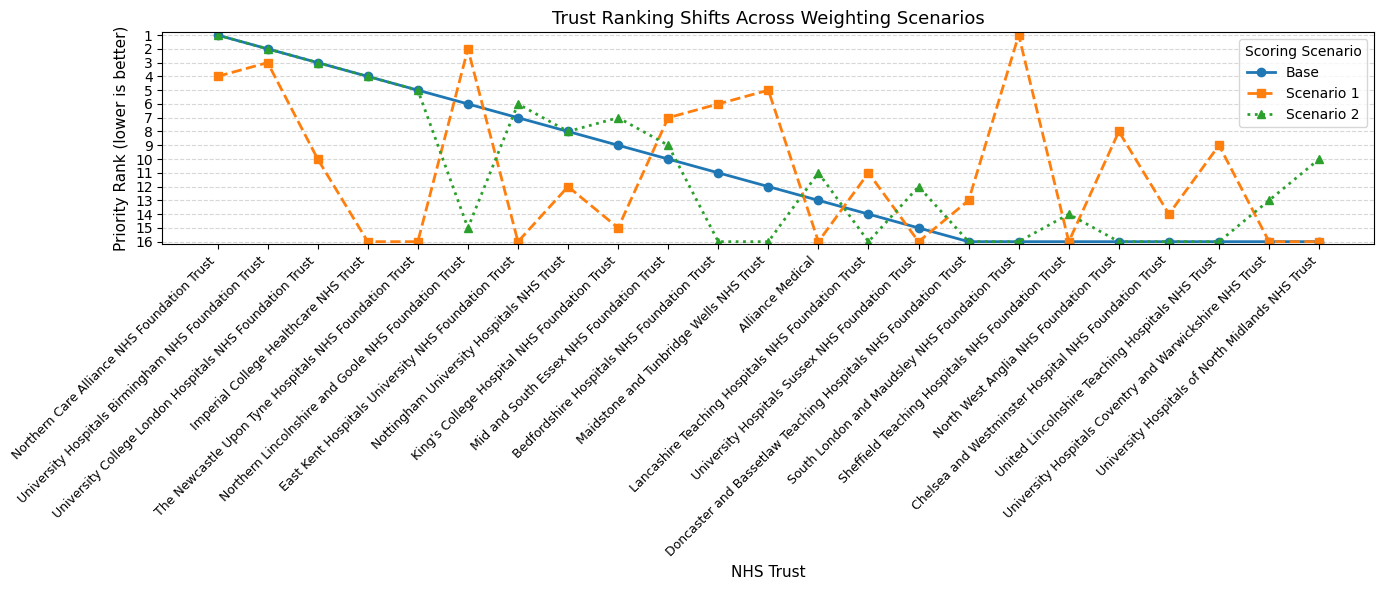

In [ ]:
# visualization
# Merge top 15 Trusts across scenarios for comparison
df_compare = (
    scenario_results['Base']
        .merge(scenario_results['Scenario1'], on='provider_name', how='outer', suffixes=('_Base', '_S1'))
        .merge(scenario_results['Scenario2'], on='provider_name', how='outer')
        .rename(columns={'priority_rank': 'priority_rank_S2'})
)

# Fill missing ranks with 16 (i.e. outside top 15)
df_compare = df_compare.fillna(16)

# Sort by Base scenario rank for visual consistency
df_compare_sorted = df_compare.sort_values('priority_rank_Base')

# Plotting: line plot by scenario
plt.figure(figsize=(14, 6))

x_labels = df_compare_sorted['provider_name']
x = np.arange(len(x_labels))

plt.plot(x, df_compare_sorted['priority_rank_Base'], marker='o', linestyle='-', linewidth=2, label='Base', color='#1f77b4')
plt.plot(x, df_compare_sorted['priority_rank_S1'], marker='s', linestyle='--', linewidth=2, label='Scenario 1', color='#ff7f0e')
plt.plot(x, df_compare_sorted['priority_rank_S2'], marker='^', linestyle=':', linewidth=2, label='Scenario 2', color='#2ca02c')

plt.xticks(ticks=x, labels=x_labels, rotation=45, ha='right', fontsize=9)
plt.yticks(np.arange(1, 17, 1))
plt.ylim(16.2, 0.8)
plt.ylabel('Priority Rank (lower is better)', fontsize=11)
plt.xlabel('NHS Trust', fontsize=11)
plt.title('Trust Ranking Shifts Across Weighting Scenarios', fontsize=13)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Scoring Scenario', loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
# === 8. Ranking Table ===
# Select the Top-15 Trusts with the highest priority scores.
# Select columns for final table
final_cols = [
    'priority_rank','priority_score',
    'provider_name','org_code','region',
    'scan_burden','scan_burden_norm',
    'wait_time','wait_time_norm',
    'volume','volume_norm',
    'gde_flag','gde_flag_norm'
]

# Top 15 Trusts
top15_table = df_ranked[final_cols].head(15)

# Display table
print(top15_table.to_string(index=False))


 priority_rank  priority_score                                            provider_name org_code region  scan_burden  scan_burden_norm  wait_time  wait_time_norm  volume  volume_norm  gde_flag  gde_flag_norm
             1        0.647060              Northern Care Alliance NHS Foundation Trust      RM3    Y62   374.315068          0.349990       34.0        0.460317 27325.0     1.000000         0              0
             2        0.634101     University Hospitals Birmingham NHS Foundation Trust      RRK    Y60   172.127660          0.159709       20.0        0.682540 24270.0     0.888177         1              1
             3        0.567026 University College London Hospitals NHS Foundation Trust      RRV    Y56   214.864865          0.199930       27.0        0.571429 23850.0     0.872804         0              0
             4        0.558822                    Imperial College Healthcare NHS Trust      RYJ    Y56   163.079470          0.151194       29.0        0.539683 24625.

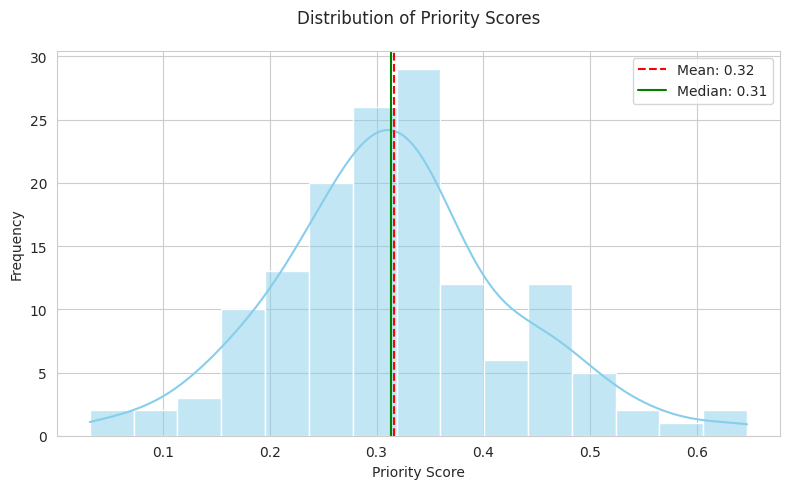

In [ ]:

# plot disstribution of priority scores
scores = df_ranked['priority_score']

sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

sns.histplot(scores, kde=True, color='skyblue', bins=15)
plt.axvline(scores.mean(), color='red', linestyle='--', label=f'Mean: {scores.mean():.2f}')
plt.axvline(scores.median(), color='green', linestyle='-', label=f'Median: {scores.median():.2f}')

plt.title('Distribution of Priority Scores', pad=20)
plt.xlabel('Priority Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

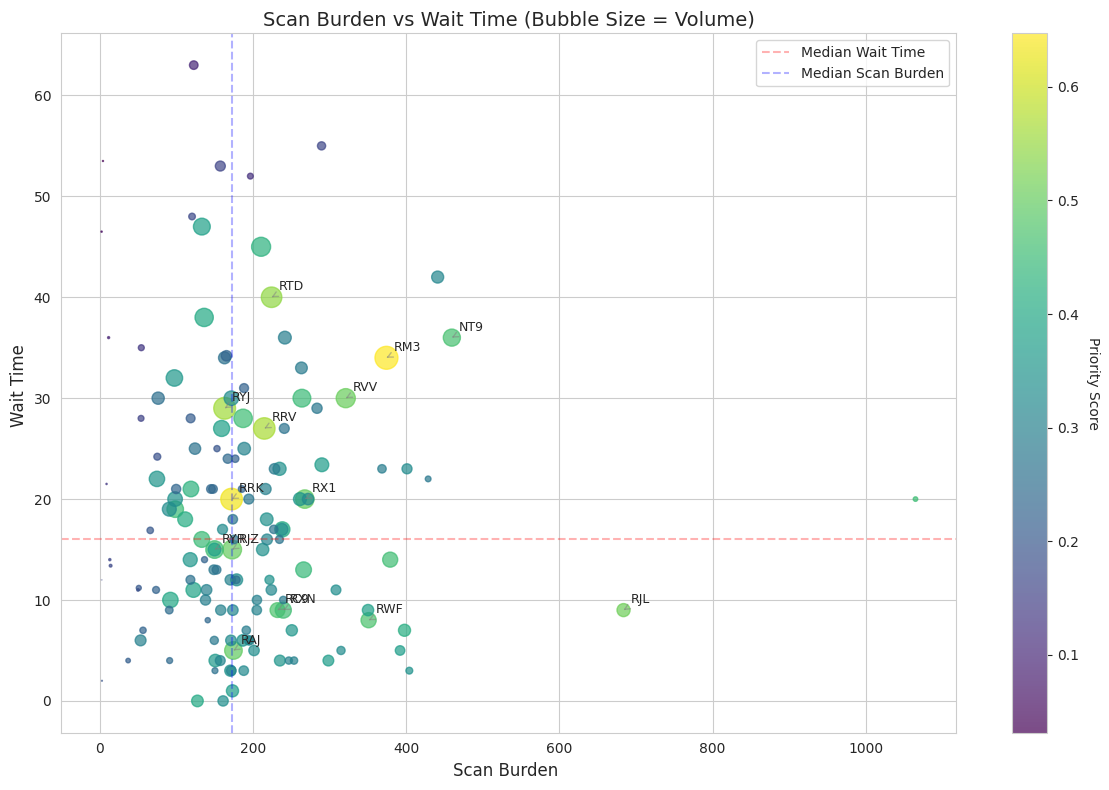

In [ ]:
# scan burden vs waiting time
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))


scatter = plt.scatter(
    x=df_ranked['scan_burden'],
    y=df_ranked['wait_time'],
    s=df_ranked['volume'] / 100,
    alpha=0.7,
    c=df_ranked['priority_score'],
    cmap='viridis'
)

plt.title("Scan Burden vs Wait Time (Bubble Size = Volume)", fontsize=14)
plt.xlabel("Scan Burden ", fontsize=12)
plt.ylabel("Wait Time ", fontsize=12)

cbar = plt.colorbar(scatter)
cbar.set_label('Priority Score', rotation=270, labelpad=15)

top5 = df_ranked.head(15)
for i, row in top5.iterrows():
    plt.annotate(
        row['org_code'],
        (row['scan_burden'], row['wait_time']),
        textcoords="offset points",
        xytext=(5,5),
        ha='left',
        fontsize=9,
        arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5)
    )

plt.axhline(y=df_ranked['wait_time'].median(), color='red', linestyle='--', alpha=0.3, label='Median Wait Time')
plt.axvline(x=df_ranked['scan_burden'].median(), color='blue', linestyle='--', alpha=0.3, label='Median Scan Burden')

plt.legend()
plt.tight_layout()
plt.show()

## K-Means Clustering (Trust Segmentation)

In [ ]:
# 7. K-Means Clustering (Trust Segmentation)
# =============================
# Cluster Trusts based on raw standardised features (not min-max)

# Optional: PCA for 2D plot

features = ['scan_burden', 'wait_time', 'volume']
X = df[features].copy()

# standization
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


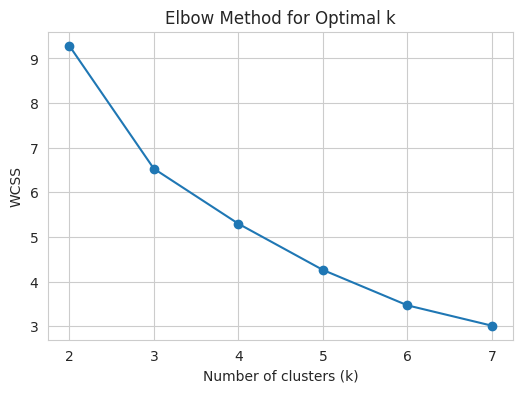

In [ ]:

# ====== 2) Elbow Method ======
# Cluster Trusts into groups with similar workload and demand profiles.
wcss = []  # Within-cluster sum of squares
K_range = range(2, 8)  # 测试 2~7 个簇
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()

In [ ]:
# ====== 3) Silhouette Score ======
sil_scores = {}
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores[k] = silhouette_score(X_scaled, labels)

print("Silhouette Scores by k:", sil_scores)

Silhouette Scores by k: {2: np.float64(0.3753940957060624), 3: np.float64(0.37910270163746607), 4: np.float64(0.3273621456635943), 5: np.float64(0.3522631111403847), 6: np.float64(0.366704063356328), 7: np.float64(0.3260323746470832)}


In [ ]:
# ====== 4) Select the final k  ======
best_k = max(sil_scores, key=sil_scores.get)
print(f"Best k by silhouette score: {best_k}")

Best k by silhouette score: 3


In [ ]:
# ====== 5) The final K-means clustering ======
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['cluster'] = kmeans_final.fit_predict(X_scaled)

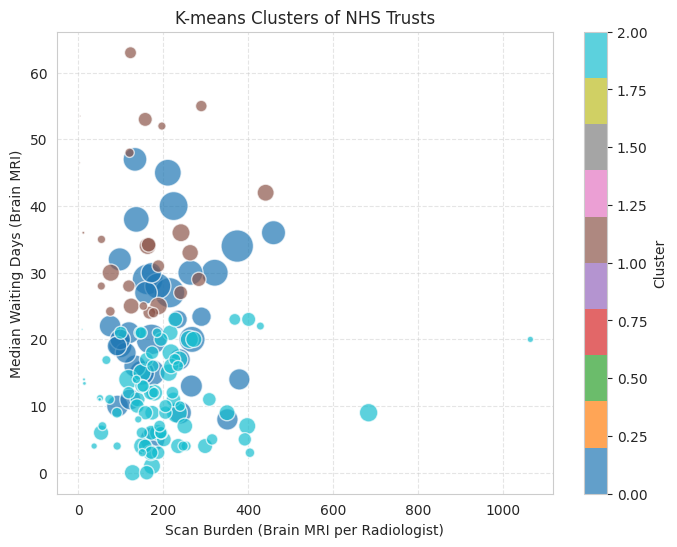

In [ ]:
# ====== 6) Bubble chart visualization ======
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    df['scan_burden'], df['wait_time'],
    s=df['volume'] / 50,
    c=df['cluster'], cmap='tab10', alpha=0.7, edgecolors='w'
)
plt.xlabel('Scan Burden (Brain MRI per Radiologist)')
plt.ylabel('Median Waiting Days (Brain MRI)')
plt.title('K-means Clusters of NHS Trusts')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# ====== 7) Examine the basic situation of each cluster ======
cluster_summary = df.groupby('cluster')[features].mean().reset_index()
print(cluster_summary)

   cluster  scan_burden  wait_time        volume
0        0   199.843906  23.182857  15307.857143
1        1   156.967407  36.207692   4214.807692
2        2   199.889115  11.059524   4570.535714


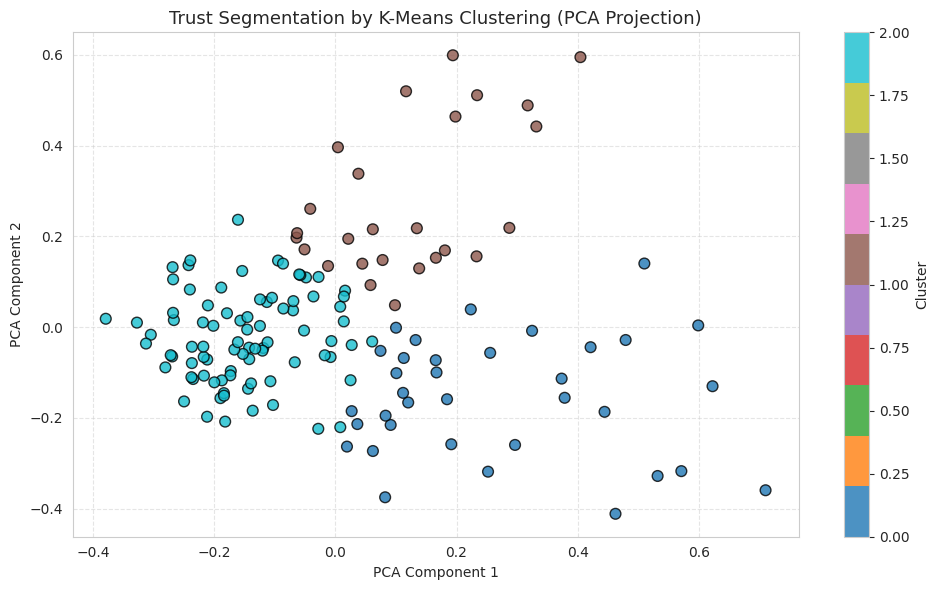

In [ ]:
# ====== 8) PCA Projection of Clusters ======
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)


df_pca = df.loc[X.index].copy()
df_pca['pca_x'] = X_pca[:, 0]
df_pca['pca_y'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_pca['pca_x'], df_pca['pca_y'],
    c=df_pca['cluster'], cmap='tab10', s=60, edgecolors='k', alpha=0.8
)


plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Trust Segmentation by K-Means Clustering (PCA Projection)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

# Combined View: Overlay Scores + Clusters

In [ ]:
# =============================
# Merge cluster_kmeans into scoring results
# Create cross-analysis table: e.g., Cluster 1 with Top 15 score

if 'deployment_phase' not in df_ranked.columns:
    df_merged = df_ranked.merge(df[['provider_name','cluster']], on='provider_name', how='left')
    high_pressure_clusters = [0]
    medium_pressure_clusters = [1]
    def assign_phase(cluster):
        if cluster in high_pressure_clusters:
            return "Phase 1 (High Priority)"
        elif cluster in medium_pressure_clusters:
            return "Phase 2 (Medium Priority)"
        else:
            return "Phase 3 (Low Priority)"
    df_merged['deployment_phase'] = df_merged['cluster'].apply(assign_phase)
else:
    df_merged = df_ranked.copy()


df_merged.head()


,provider_name,org_code,region,volume,clinical_radiology_fte,wait_time,gde_flag,scan_burden,scan_burden_norm,volume_norm,gde_flag_norm,wait_time_norm,priority_score,priority_rank,cluster,deployment_phase
0,Northern Care Alliance NHS Foundation Trust,RM3,Y62,27325.0,73.0,34.0,0,374.315068,0.349990,1.000000,0,0.460317,0.647060,1,0,Phase 1 (High Priority)
1,University Hospitals Birmingham NHS Foundation...,RRK,Y60,24270.0,141.0,20.0,1,172.127660,0.159709,0.888177,1,0.682540,0.634101,2,0,Phase 1 (High Priority)
2,University College London Hospitals NHS Founda...,RRV,Y56,23850.0,111.0,27.0,0,214.864865,0.199930,0.872804,0,0.571429,0.567026,3,0,Phase 1 (High Priority)
3,Imperial College Healthcare NHS Trust,RYJ,Y56,24625.0,151.0,29.0,0,163.079470,0.151194,0.901171,0,0.539683,0.558822,4,0,Phase 1 (High Priority)
4,The Newcastle Upon Tyne Hospitals NHS Foundati...,RTD,Y63,21760.0,97.0,40.0,1,224.329897,0.208837,0.796303,1,0.365079,0.544004,5,0,Phase 1 (High Priority)


# Visualisations

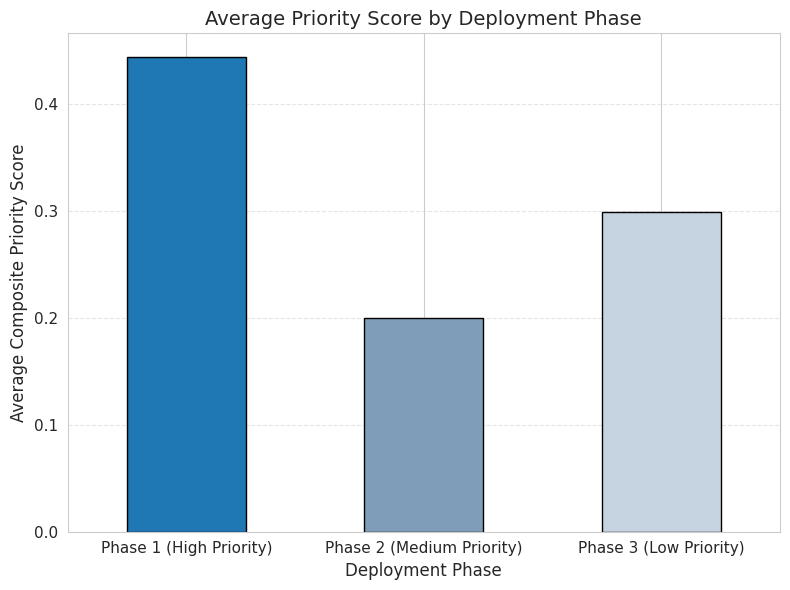

In [ ]:
# === Calculate average priority score for each deployment phase ===
phase_avg = df_merged.groupby('deployment_phase')['priority_score'].mean().reindex([
    'Phase 1 (High Priority)',
    'Phase 2 (Medium Priority)',
    'Phase 3 (Low Priority)'
])

# === Plot bar chart ===
plt.figure(figsize=(8, 6))
phase_avg.plot(
    kind='bar',
    color=['#1f77b4', '#7f9db9', '#c6d4e1'],
    edgecolor='black'
)

# === Chart formatting ===
plt.title("Average Priority Score by Deployment Phase", fontsize=14)
plt.ylabel("Average Composite Priority Score", fontsize=12)
plt.xlabel("Deployment Phase", fontsize=12)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# select Phase 1 and rank
phase1_top15 = (
    df_merged[df_merged['deployment_phase'] == "Phase 1 (High Priority)"]
    .sort_values('priority_score', ascending=False)
    .head(15)
    [['priority_rank', 'priority_score', 'provider_name', 'scan_burden', 'wait_time', 'volume','deployment_phase']]
)

phase1_top15.reset_index(drop=True, inplace=True)
phase1_top15

,priority_rank,priority_score,provider_name,scan_burden,wait_time,volume,deployment_phase
0,1,0.647060,Northern Care Alliance NHS Foundation Trust,374.315068,34.0,27325.0,Phase 1 (High Priority)
1,2,0.634101,University Hospitals Birmingham NHS Foundation...,172.127660,20.0,24270.0,Phase 1 (High Priority)
2,3,0.567026,University College London Hospitals NHS Founda...,214.864865,27.0,23850.0,Phase 1 (High Priority)
3,4,0.558822,Imperial College Healthcare NHS Trust,163.079470,29.0,24625.0,Phase 1 (High Priority)
4,5,0.544004,The Newcastle Upon Tyne Hospitals NHS Foundati...,224.329897,40.0,21760.0,Phase 1 (High Priority)
5,7,0.506811,East Kent Hospitals University NHS Foundation ...,321.186441,30.0,18950.0,Phase 1 (High Priority)
6,8,0.502380,Nottingham University Hospitals NHS Trust,267.727273,20.0,17670.0,Phase 1 (High Priority)
7,9,0.502167,King's College Hospital NHS Foundation Trust,172.830189,15.0,18320.0,Phase 1 (High Priority)
8,10,0.497177,Mid and South Essex NHS Foundation Trust,174.565217,5.0,16060.0,Phase 1 (High Priority)
9,12,0.469530,Maidstone and Tunbridge Wells NHS Trust,351.029412,8.0,11935.0,Phase 1 (High Priority)


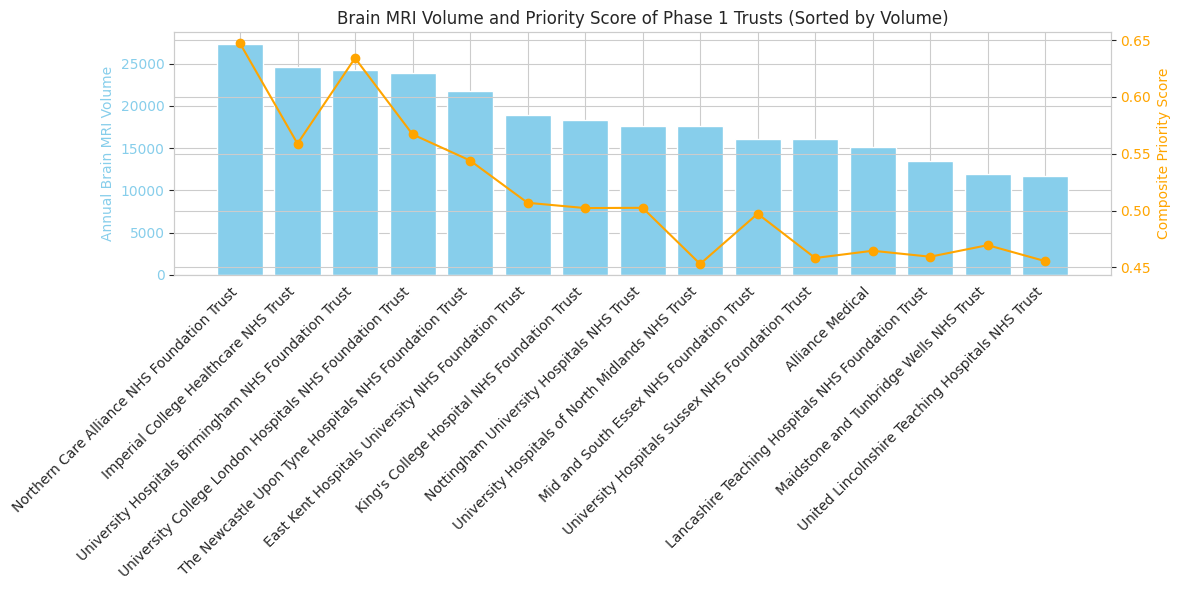

In [ ]:
# Sort by volume in descending order
phase1_top15_sorted = phase1_top15.sort_values(by='volume', ascending=False)

# Plot using sorted data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot: Brain MRI Volume (Primary Y-axis)
ax1.bar(phase1_top15_sorted['provider_name'], phase1_top15_sorted['volume'], color='skyblue')
ax1.set_ylabel('Annual Brain MRI Volume', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(phase1_top15_sorted['provider_name'], rotation=45, ha='right')

# Line plot: Priority Score (Secondary Y-axis)
ax2 = ax1.twinx()
ax2.plot(phase1_top15_sorted['provider_name'], phase1_top15_sorted['priority_score'], color='orange', marker='o')
ax2.set_ylabel('Composite Priority Score', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title
plt.title('Brain MRI Volume and Priority Score of Phase 1 Trusts (Sorted by Volume)')
plt.tight_layout()
plt.show()
